# **CheXpert Chest X-Ray Dataset**

- [dataset](https://stanfordmlgroup.github.io/competitions/chexpert/)
- [Read the Paper (Irvin & Rajpurkar et al.)](https://arxiv.org/abs/1901.07031)


## What is CheXpert?

CheXpert is a large dataset of chest X-rays and competition for automated chest x-ray interpretation, which features uncertainty labels and radiologist-labeled reference standard evaluation sets.


## Why CheXpert?

Chest radiography is the most common imaging examination globally, critical for screening, diagnosis, and management of many life threatening diseases. Automated chest radiograph interpretation at the level of practicing radiologists could provide substantial benefit in many medical settings, from improved workflow prioritization and clinical decision support to large-scale screening and global population health initiatives. For progress in both development and validation of automated algorithms, we realized there was a need for a labeled dataset that (1) was large, (2) had strong reference standards, and (3) provided expert human performance metrics for comparison.

---

## In the CheXpert series:

- [**🩻 CheXpert X-Rays Dataset | Data Visuals 🫁**](https://www.kaggle.com/code/shreydan/chexpert-x-rays-dataset-data-visuals): we explored the dataset visually as per the diseases
- [**🩻 CheXpert | multi-label classifier 📊️**](https://www.kaggle.com/code/shreydan/chexpert-multi-label-classifier/): we trained a multi-label classifier for the following labels: Atelectasis, Cardiomegaly, Consolidation, Edema, Pleural Effusion. We used asymmetric loss function with multiple metrics: auroc, specificity, hamming_loss, exact_match.
- [**🩻 CheXpert | TTA labeling**](https://www.kaggle.com/code/shreydan/chexpert-tta-labeling): we applied test-time augmentation of uncertain labels to select a final label based on the most-occuring label out of 5 predictions on 1 sample.

### In this notebook, we'll be training a multi-label image classifier on the CheXpert dataset for the following labels: 

| Term             | Description                                                               |
|-----------------|:--------------------------------------------------------------------------|
| Atelectasis      | Incomplete collapse of lung tissue                                        |
| Cardiomegaly     | Enlargement of the heart                                                  |
| Consolidation    | Filling of air spaces in the lung with fluid                              |
| Edema            | Excess fluid in the tissues                                               |
| Pleural Effusion | Abnormal collection of fluid in the space between the lung and chest wall |

### We'll be using the original labels along with the generated pseudo-labels
#### do checkout the previous classification notebook on more details on dataset preparation.

# Imports

In [1]:
!pip install -Uq transformers accelerate datasets

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from PIL import Image
from torchvision.utils import make_grid
import torchvision.transforms.functional as TF
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedGroupKFold
from pathlib import Path
from collections import Counter
import datasets
from transformers import AutoModelForImageClassification, Trainer, TrainingArguments
from torchmetrics.functional.classification import (multilabel_auroc, 
                                                    multilabel_exact_match,
                                                    multilabel_specificity,
                                                    multilabel_hamming_distance
                                                   )
from types import SimpleNamespace

from huggingface_hub import login

tqdm.pandas()

2024-05-21 07:51:01.217894: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 07:51:01.217988: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 07:51:01.321368: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
hfkey = user_secrets.get_secret("hfkeywrite")
login(token=hfkey)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


# Basic Data Preparation

- I'll be splitting the `train` dataset into train and validation.
- I'll be using the `validation` dataset for testing.

In [4]:
base_path = Path('/kaggle/input/chexpert')

In [5]:
# generated from the TTA notebook 
train_df = pd.read_csv('/kaggle/input/chexpert-tta-labeling/train_df.csv')

test_df = pd.read_csv('/kaggle/input/chexpert/CheXpert-v1.0-small/valid.csv')
test_df['Path'] = test_df['Path'].progress_map(lambda p: base_path/Path(p))

  0%|          | 0/234 [00:00<?, ?it/s]

# Target Columns for Training Models

- we have all possible labels: `all_target_cols`
- labels which were specific to CheXpert competition: `target_cols`

In [6]:
all_target_cols = [
    'No Finding',
    'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
    'Support Devices'
]
target_cols = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

keep_cols = ['Path','PatientID'] + target_cols

In [7]:
train_df.head()

,Path,PatientID,fold,labels
0,/kaggle/input/chexpert/CheXpert-v1.0-small/tra...,42990,5,"1,0,0,0,0"
1,/kaggle/input/chexpert/CheXpert-v1.0-small/tra...,33251,6,"0,0,0,1,0"
2,/kaggle/input/chexpert/CheXpert-v1.0-small/tra...,1757,4,"1,0,0,0,1"
3,/kaggle/input/chexpert/CheXpert-v1.0-small/tra...,20265,5,"0,0,0,0,0"
4,/kaggle/input/chexpert/CheXpert-v1.0-small/tra...,7488,7,"0,0,0,1,1"


In [8]:
test_df.fillna(value=0,inplace=True)
test_df[all_target_cols] = test_df[all_target_cols].astype(int)

In [9]:
test_df = test_df.drop(columns=[c for c in test_df.columns if c not in keep_cols])
test_df['Path'] = test_df['Path'].progress_map(lambda p:str(p))

  0%|          | 0/234 [00:00<?, ?it/s]

# Train-Valid Split
- we had previously used `StratifiedGroupKFold` to split the dataset, Grouping is done based on patient ID to not have any overlaps.

In [10]:
def combine_label_cols(df, label_cols):
    combine = lambda x: ','.join([f"{x[c]}" for c in label_cols])
    df['labels'] = df.progress_apply(combine, axis=1)
    df = df.drop(columns=label_cols)
    return df.reset_index(drop=True)

def get_fold(df,fold=0):
    train = df[df['fold']!=fold].reset_index(drop=True)
    valid = df[df['fold']==fold].reset_index(drop=True)
    return train, valid

In [11]:
fold_0_train,fold_0_valid = get_fold(train_df, fold=0)
len(fold_0_train), len(fold_0_valid)

(195851, 27563)

# Label Distribution

In [12]:
dist_df = train_df.copy()
dist_df[target_cols] = dist_df['labels'].str.split(',',expand=True)
dist_df[target_cols] = dist_df[target_cols].astype(int)
dist_train, dist_valid = get_fold(dist_df, fold=0)

ones = 0
zeros = 0
for col in target_cols:
    t = dist_train[col].value_counts().to_dict()
    v = dist_valid[col].value_counts().to_dict()
    te = test_df[col].value_counts().to_dict()
    print(col)
    for k in [0,1]:
        print(f"{k}\ttrain: {t[k]} valid: {v[k]} test: {te.get(k,0)}")
    print()
    zeros += t[0]
    ones += t[1]
  
print('possible gamma_neg for the loss_fn:',zeros//ones)

Atelectasis
0	train: 154210 valid: 21667 test: 154
1	train: 41641 valid: 5896 test: 80

Cardiomegaly
0	train: 169344 valid: 23893 test: 166
1	train: 26507 valid: 3670 test: 68

Consolidation
0	train: 182131 valid: 25731 test: 201
1	train: 13720 valid: 1832 test: 33

Edema
0	train: 141971 valid: 20084 test: 189
1	train: 53880 valid: 7479 test: 45

Pleural Effusion
0	train: 113402 valid: 16000 test: 167
1	train: 82449 valid: 11563 test: 67

possible gamma_neg for the loss_fn: 3


## We're combining the labels into a list so that it becomes easier to one-hot encode

In [13]:
target_cols = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']
id2label = {i:l for i,l in enumerate(target_cols)}
label2id = {l:i for i,l in id2label.items()}

test_df_combined = combine_label_cols(test_df, target_cols)
fold_0_train.head()

  0%|          | 0/234 [00:00<?, ?it/s]

,Path,PatientID,fold,labels
0,/kaggle/input/chexpert/CheXpert-v1.0-small/tra...,42990,5,"1,0,0,0,0"
1,/kaggle/input/chexpert/CheXpert-v1.0-small/tra...,33251,6,"0,0,0,1,0"
2,/kaggle/input/chexpert/CheXpert-v1.0-small/tra...,1757,4,"1,0,0,0,1"
3,/kaggle/input/chexpert/CheXpert-v1.0-small/tra...,20265,5,"0,0,0,0,0"
4,/kaggle/input/chexpert/CheXpert-v1.0-small/tra...,7488,7,"0,0,0,1,1"


# Creating a Dataset using Hugging Face Datasets

In [14]:
train_ds = datasets.Dataset.from_pandas(fold_0_train).cast_column('Path',datasets.Image())
valid_ds = datasets.Dataset.from_pandas(fold_0_valid).cast_column('Path',datasets.Image())
test_ds = datasets.Dataset.from_pandas(test_df_combined).cast_column('Path',datasets.Image())
len(train_ds), len(valid_ds), len(test_ds)

(195851, 27563, 234)

# Training and Validation Augmentations

In [15]:
img_size = 384
mean = (0.485,0.456,0.406)
std = (0.229,0.224,0.225)
train_tfms = A.Compose([
    A.Rotate(15),
    A.Resize(img_size,img_size),
    A.HorizontalFlip(),
    A.Normalize(mean=mean,std=std),
    ToTensorV2(),
])
valid_tfms = A.Compose([
    A.Resize(img_size,img_size),
    A.Normalize(mean=mean,std=std),
    ToTensorV2(),
])

In [16]:
def train_transforms(batch):
    batch['image'] = [np.array(x.convert('RGB')) for x in batch['Path']]
    batch['image'] = [train_tfms(image=x)['image'] for x in batch['image']]
    batch['labels'] = [list(map(int,l.split(','))) for l in batch['labels']]
    return batch

def valid_transforms(batch):
    batch['image'] = [np.array(x.convert('RGB')) for x in batch['Path']]
    batch['image'] = [valid_tfms(image=x)['image'] for x in batch['image']]
    batch['labels'] = [list(map(int,l.split(','))) for l in batch['labels']]
    return batch

In [17]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['image'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [18]:
train_ds = train_ds.with_transform(train_transforms)
valid_ds = valid_ds.with_transform(valid_transforms)
test_ds = test_ds.with_transform(valid_transforms)

# Asymmetric Loss

- paper: [Asymmetric Loss for multilabel classification](https://arxiv.org/abs/2009.14119)
- idea: In this paper, we introduce a novel asymmetric loss (”ASL”), which operates differently on positive and negative samples. The loss enables to dynamically down-weights and hard-thresholds easy negative samples, while also discarding possibly mislabeled samples.

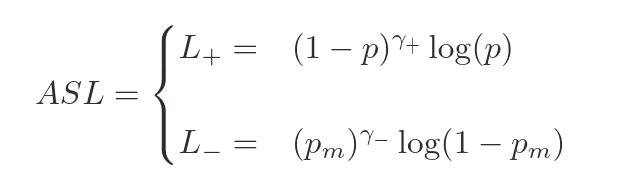

- explanation: We propose to decouple the focusing levels of the positive and negative samples. Let γ+ and γ− be the positive and negative focusing parameters, respectively. We obtain asymmetric focusing by redefining the loss: Since we are interested in emphasizing the contribution of positive samples, we usually set γ− > γ+. Asymmetric focusing decouples the decay rates of positive and negative samples. Through this, we achieve better control over the contribution of positive and negative samples to the loss function, and help the network learn meaningful features from positive samples, despite their rarity.


> In the previous notebook we had used masking to mask out uncertain labels, here we dont have to do that

In [19]:
class AsymmetricLossOptimized(nn.Module):
    ''' Notice - optimized version, minimizes memory allocation and gpu uploading,
    favors inplace operations'''

    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=False):
        super(AsymmetricLossOptimized, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

        # prevent memory allocation and gpu uploading every iteration, and encourages inplace operations
        self.targets = self.anti_targets = self.xs_pos = self.xs_neg = self.asymmetric_w = self.loss = None

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        self.targets = y
        self.anti_targets = 1 - y

        # Calculating Probabilities
        self.xs_pos = torch.sigmoid(x)
        self.xs_neg = 1.0 - self.xs_pos

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            self.xs_neg.add_(self.clip).clamp_(max=1)

        # Basic CE calculation
        self.loss = self.targets * torch.log(self.xs_pos.clamp(min=self.eps))
        self.loss.add_(self.anti_targets * torch.log(self.xs_neg.clamp(min=self.eps)))

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            self.xs_pos = self.xs_pos * self.targets
            self.xs_neg = self.xs_neg * self.anti_targets
            self.asymmetric_w = torch.pow(1 - self.xs_pos - self.xs_neg,
                                          self.gamma_pos * self.targets + self.gamma_neg * self.anti_targets)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            self.loss *= self.asymmetric_w
   
        return -self.loss.mean()

# Model
---
we'll be training an entirely fresh model instead of continuing with the previous cheXpert model.

In [20]:
model = AutoModelForImageClassification.from_pretrained(
    'facebook/convnextv2-tiny-22k-384',
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True
)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/115M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of ConvNextV2ForImageClassification were not initialized from the model checkpoint at facebook/convnextv2-tiny-22k-384 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Metrics

- the metrics used in the CheXpert paper is label-wise `AUROC`
- I also included additional metrics: 
    - label-wise `Specificity`: (true negative rate) is the probability of a negative test result, conditioned on the individual truly being negative.
    - `Exact Match`: all the labels for a sample must match exactly
    - Hamming Distance: the Hamming distance between two strings or vectors of equal length is the number of positions at which the corresponding symbols are different

In [21]:
def compute_metrics(eval_preds):
    """
    ignore_index=-1 is unnecessary since we dont have uncertain labels anymore 
                    but keeping it for consistency
    """
    target_cols = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']
    logits, labels = eval_preds
    logits, labels = torch.from_numpy(logits), torch.from_numpy(labels).long()
    auroc = multilabel_auroc(logits, labels,num_labels=5,ignore_index=-1,average='none').numpy()
    exact_match = multilabel_exact_match(logits, labels, num_labels=5,ignore_index=-1).item()
    specificity = multilabel_specificity(logits, labels, num_labels=5,ignore_index=-1,average='none').numpy()
    hamming_dist = multilabel_hamming_distance(logits, labels, num_labels=5,ignore_index=-1).item()
    
    auroc_values = {f"auroc_{c}":a for c,a in zip(target_cols, auroc)}
    specificity_values = {f"specificity_{c}":a for c,a in zip(target_cols, specificity)}
    return {
        **auroc_values,
        **specificity_values,
        'exact_match': exact_match,
        'hamming_distance': hamming_dist
    }

# Trainer

In [22]:
class ChexpertTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop('labels')
        outputs = model(**inputs)
        loss = AsymmetricLossOptimized(gamma_neg=3)(outputs.logits, labels)
        
        return (loss, outputs) if return_outputs else loss

In [23]:
training_args = TrainingArguments(
    output_dir="./CheXpert-5-convnextv2-tiny-384",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    dataloader_num_workers=4,
    do_eval=True,
    dataloader_drop_last=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=500,
    lr_scheduler_type='cosine',
    warmup_steps=2500,
    num_train_epochs=6,
    learning_rate=1e-3,
    weight_decay=0.02,
    remove_unused_columns=False,
    push_to_hub=True,
    report_to='tensorboard',
    load_best_model_at_end=True,
)

In [24]:
trainer = ChexpertTrainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=valid_ds
)

In [25]:
trainer.train()

Epoch,Training Loss,Validation Loss,Auroc Atelectasis,Auroc Cardiomegaly,Auroc Consolidation,Auroc Edema,Auroc Pleural effusion,Specificity Atelectasis,Specificity Cardiomegaly,Specificity Consolidation,Specificity Edema,Specificity Pleural effusion,Exact Match,Hamming Distance
1,0.089100,0.089329,0.732329,0.836649,0.702013,0.838670,0.870152,0.451037,0.966127,1.000000,0.659562,0.539202,0.261578,0.244425
2,0.085400,0.083060,0.753476,0.855615,0.734970,0.865072,0.888145,0.729304,0.904242,0.993585,0.708267,0.625922,0.357070,0.197263
3,0.082000,0.082400,0.768300,0.869640,0.747261,0.871969,0.896068,0.695554,0.819621,0.988104,0.608715,0.661060,0.329849,0.217690
4,0.079900,0.080230,0.774888,0.871990,0.756199,0.878270,0.900502,0.745048,0.883055,0.960773,0.734064,0.698449,0.380226,0.188030
5,0.075900,0.079298,0.779508,0.874582,0.758260,0.881833,0.903021,0.727688,0.894821,0.971114,0.761803,0.704452,0.386941,0.182346
6,0.073900,0.079802,0.778702,0.872732,0.756064,0.881221,0.903072,0.746064,0.892141,0.969015,0.748655,0.707390,0.388611,0.182361


TrainOutput(global_step=36720, training_loss=0.08228830044565637, metrics={'train_runtime': 33327.5761, 'train_samples_per_second': 35.259, 'train_steps_per_second': 1.102, 'total_flos': 8.69220353500722e+19, 'train_loss': 0.08228830044565637, 'epoch': 6.0})

In [26]:
trainer.evaluate(test_ds)

{'eval_loss': 0.1008862853050232,
 'eval_auroc_Atelectasis': 0.7943280935287476,
 'eval_auroc_Cardiomegaly': 0.8186613321304321,
 'eval_auroc_Consolidation': 0.9268602728843689,
 'eval_auroc_Edema': 0.9233385920524597,
 'eval_auroc_Pleural Effusion': 0.9315304756164551,
 'eval_specificity_Atelectasis': 0.7891156673431396,
 'eval_specificity_Cardiomegaly': 1.0,
 'eval_specificity_Consolidation': 0.9947643876075745,
 'eval_specificity_Edema': 0.8406593203544617,
 'eval_specificity_Pleural Effusion': 0.8037974834442139,
 'eval_exact_match': 0.4464285671710968,
 'eval_hamming_distance': 0.1803571581840515,
 'eval_runtime': 3.1924,
 'eval_samples_per_second': 73.3,
 'eval_steps_per_second': 2.506,
 'epoch': 6.0}

# Uploading model to HF Hub

In [27]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "tags": ['image-classification'],
}
trainer.save_model()
trainer.push_to_hub('CheXpert 5 labels 🩻', **kwargs)

events.out.tfevents.1716311215.b0835b462e36.24.1:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/shreydan/CheXpert-5-convnextv2-tiny-384/commit/44822e75a0f4a4d543dfe8e8229bad0665d9696c', commit_message='CheXpert 5 labels \U0001fa7b', commit_description='', oid='44822e75a0f4a4d543dfe8e8229bad0665d9696c', pr_url=None, pr_revision=None, pr_num=None)

# Thank You for Checking Out My Work!

## Follow [**@shreydan**](https://kaggle.com/shreydan) if you haven't already!